# **Âge et Genre : Prédire le genre et l'âge d'une personne**

# 1. Importations des données

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 2. Pré-traitement des données du dataset
### a) Récupérer les labels (âge et genre)
### b) Séprarer les données

In [2]:
def preprocess_utkface_dataset(dataset_path, output_base_path):
    """
    @params : 
        - dataset_path (string) : Chemin vers le dataset
        - output_path (string) : Chemin où seront envoyées les données
        
    @description : Fonction qui permet de récupérer les informations utiles qui serviront pour le model plus tard et d'organiser les données qui seront utilisées
    en différentes catégories : train, validation(val) et test puis selon leur genre et âge

    @returns : df (DataFrame) : Données contenant age, genre et chemin de l'image
    """
    
    image_paths = [] # Initialisation du tableau qui contiendra le chemin des images
    gender_labels = [] # Initialisation du tableau qui contiendra les labels (genres) des images
    age_labels = [] # Initialisation du tableau qui contiendra les labels (âges) des images

    for filename in os.listdir(dataset_path): # On parcourt chaque fichier du dataset
        image_path = os.path.join(dataset_path, filename) # On récupère son chemin absolu
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')): # On vérifie que ce sont bien des images par leurs extensions
            continue # On ignore les fichiers qui sont pas des images

        try:
            age, gender, _, _ = filename.split('_') # On récupère l'age et le genre 
            image_paths.append(image_path) # On ajoute le chemin de l'image au tableau associé
            gender_labels.append(int(gender)) # On ajoute le chemin de les labels de genre au tableau associé
            age_labels.append(int(age)) # On ajoute le chemin de les labels d'âge au tableau associé
        except:
            print(f"Format invalide : {filename}") # On affiche lorsqu'un fichier ne correspond pas au format : age_genre_x_x

    if not image_paths: # Si le tableau image_paths est vide,
        raise ValueError("Aucune image valide trouvée.") # c'est qu'aucune image valide n'a été trouvée

    df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels}) # On stocke les données dans un 

   # On sépare les données : 60% pour le train et 40% de données temporaires
    x_train, x_temp, y_train_age, y_temp_age, y_train_gender, y_temp_gender = train_test_split(df['image'], df['age'], df['gender'], test_size=0.4, random_state=42)
   # On sépare les données temporaires : 50% pour la validation et 50% pour le test (soit 20% du total des données)
    x_val, x_test, y_val_age, y_test_age, y_val_gender, y_test_gender = train_test_split(x_temp, y_temp_age, y_temp_gender, test_size=0.5, random_state=42)

    # Fonction pour créer les dossiers et copier les images
    def copy_images(image_paths, ages, genders, split):
        for image_path, age, gender in zip(image_paths, ages, genders): # On parcourt chaque image du dataset
            gender_folder = 'male' if gender == 0 else 'female' # Le nom du dossier sera le genre de la personne
            age_folder = f"age_{age}" # Nom du dossier par rapport à l'âge
            dest_folder = os.path.join(output_base_path, split, gender_folder, age_folder) # Récupération du dossier où seront stockées les images (dépends de leur split)
            os.makedirs(dest_folder, exist_ok=True) # Créer les différents dossiers si ils n'existent pas (genre et age)
            shutil.copy(image_path, dest_folder) # Duplique les images vers leur dossier respectif selon leur genre et age

    # Appel de la fonction pour créer les différents dossiers selon leur split (si les images serviront pour le train, la validation ou le test)
    copy_images(x_train, y_train_age, y_train_gender, 'train')
    copy_images(x_val, y_val_age, y_val_gender, 'val')
    copy_images(x_test, y_test_age, y_test_gender, 'test')

    return [df, x_train, y_train_age, y_train_gender, x_val, y_val_age, y_val_gender, x_test, y_test_age, y_test_gender]

In [3]:
dataset_path = "/kaggle/input/face-dataset/UTKFace"
output_base_path = "/kaggle/working/dataset"


res = preprocess_utkface_dataset(dataset_path, output_base_path)
print(res[0].head())

Format invalide : 61_1_20170109142408075.jpg.chip.jpg
Format invalide : 61_1_20170109150557335.jpg.chip.jpg
Format invalide : 39_1_20170116174525125.jpg.chip.jpg
                                               image  age  gender
0  /kaggle/input/face-dataset/UTKFace/26_0_2_2017...   26       0
1  /kaggle/input/face-dataset/UTKFace/22_1_1_2017...   22       1
2  /kaggle/input/face-dataset/UTKFace/21_1_3_2017...   21       1
3  /kaggle/input/face-dataset/UTKFace/28_0_0_2017...   28       0
4  /kaggle/input/face-dataset/UTKFace/17_1_4_2017...   17       1


In [4]:
x_train, y_train_age, y_train_gender, x_val, y_val_age, y_val_gender, x_test, y_test_age, y_test_gender = res[1], res[2], res[3], res[4], res[5], res[6], res[7], res[8], res[9]

# 3. Visualisation de quelques images du dataset en affichant âge et genre

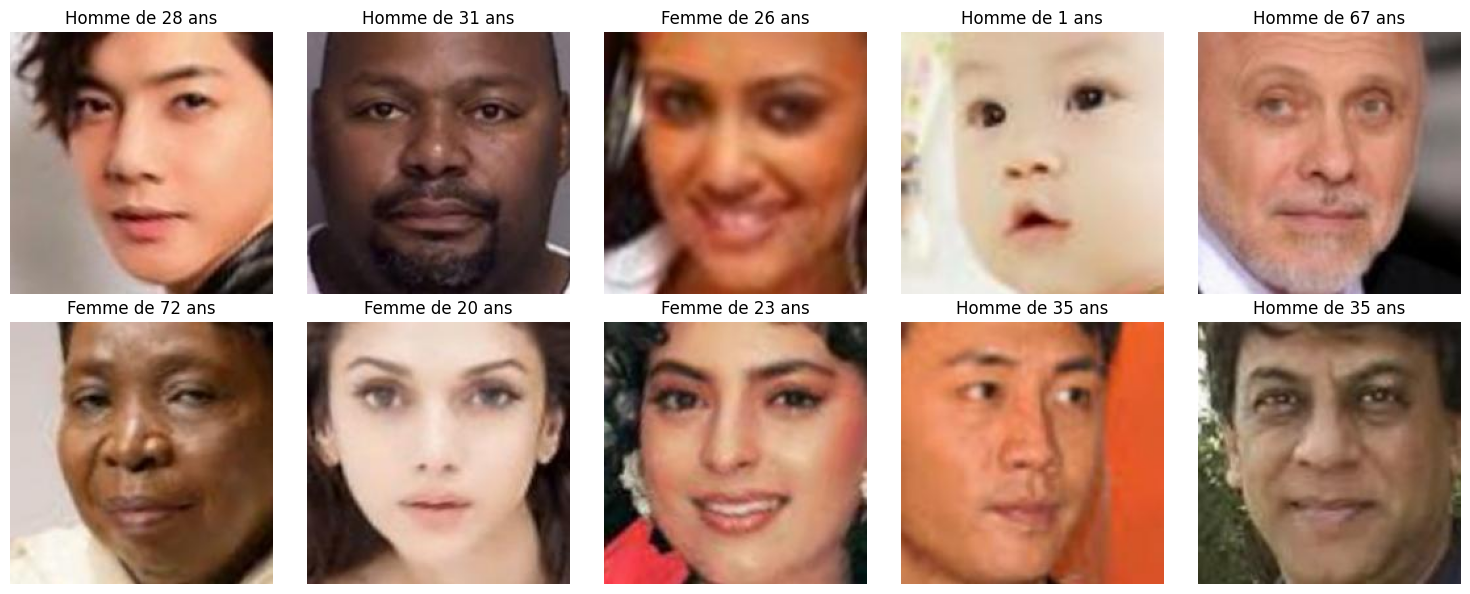

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

sample_df = res[0].sample(n=10, random_state=42) # Sélectionner 10 images aléatoirement
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Création d'une figure pour afficher 10 images -> 2 lignes, 5 colonnes

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()): # Parmis les 10 images choisies
    img = Image.open(row['image'])  # Ouvrir l'image
    gender = "Homme" if row['gender'] == 0 else "Femme" # On récupère son genre
    age = row['age'] # On récupère son âge
    
    ax.imshow(img)  # Afficher l'image
    ax.set_title(f"{gender} de {age} ans", fontsize=12)  # Ajouter le titre 
    ax.axis('off')  # Cacher les axes

plt.tight_layout()  # Ajuster la disposition
plt.show()

# 3. Normalisation des données

In [6]:
y_train_age = y_train_age / 116
y_val_age = y_val_age / 116
y_test_age = y_test_age / 116

# 4. Séparation dans différents dossiers

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Charger les datasets pour Train, Validation et Test

# Ces données seront utilisées pour entrainer le modèle
train_ds = image_dataset_from_directory(
    directory="/kaggle/working/dataset/train", # Emplacement du dossier train crée précédemment notre fonction preprocess
    class_names=["female", "male"],  # Les classes dans le bon ordre
    batch_size=32, # Les images seront chargées par lot de 32
    image_size=(128, 128), # On les redimensionne en 128x128 pixels
    label_mode="int",  # Utiliser des entiers pour les étiquettes
    shuffle=True, # On mélange aléatoirement les images pour éviter un ordre
    seed=42,
)
# Ces données seront utilisées pour évaluer le modèle
val_ds = image_dataset_from_directory(
    directory="/kaggle/working/dataset/val",
    class_names=["female", "male"],
    batch_size=32,
    image_size=(128, 128),
    label_mode="int",
    shuffle=False,  # Pas besoin de mélanger pour la validation
)
# Ces données seront utilisées pour tester le modèle
test_ds = image_dataset_from_directory(
    directory="/kaggle/working/dataset/test",
    class_names=["female", "male"],
    batch_size=32,
    image_size=(128, 128),
    label_mode="int",
    shuffle=False,  # Pas besoin de mélanger pour le test
)

Found 14223 files belonging to 2 classes.
Found 4741 files belonging to 2 classes.
Found 4741 files belonging to 2 classes.


# 5. Pré-traitement des données que nous allons utiliser pour entrainer le modèle
### a) Ajouter des effets aléatoires aux images

In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

def preprocess_utkface(image, label, mode='train'):
    """Preprocessing and data augmentation function."""

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize pixels between 0 and 1

    if mode == 'train':
        image = tf.image.random_flip_left_right(image)
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)
        image = tf.image.adjust_brightness(image, delta=-0.05)


    return image, label

# Efficient image loading and preprocessing
def load_and_preprocess_image(image_path, label_age, label_gender, mode='train'):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
  return preprocess_utkface(image, (label_age, label_gender), mode=mode)


# Create tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_age, y_train_gender))
train_ds = train_ds.map(lambda image_path, label_age, label_gender: load_and_preprocess_image(image_path, label_age, label_gender, mode='train'))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_age, y_val_gender))
val_ds = val_ds.map(lambda image_path, label_age, label_gender: load_and_preprocess_image(image_path, label_age, label_gender, mode='eval'))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_age, y_test_gender))
test_ds = test_ds.map(lambda image_path, label_age, label_gender: load_and_preprocess_image(image_path, label_age, label_gender, mode='test'))


BUFFER_SIZE = len(x_train)
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# 6. Définition du modèle

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Définition de l'architecture du modèle (approche non séquentielle)
inputs = tf.keras.Input(shape=(128, 128, 3))

# Couches convolutionnelles
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Aplatir les features
x = layers.Flatten()(x)

# Branche pour l'âge
age_branch = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
age_branch = layers.Dropout(0.3)(age_branch)
age_output = layers.Dense(1, activation='linear', name='age_output')(age_branch)

# Branche pour le genre
gender_branch = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
gender_branch = layers.Dropout(0.3)(gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# Création du modèle
model = Model(inputs=inputs, outputs=[age_output, gender_output])

metrics = {
    'gender_output': ['accuracy'],  # Accuracy pour le genre
    'age_output': ['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # MAE, MSE, RMSE pour l'âge
}

# Compiler le modèle avec des pertes et des métriques adaptées
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
              metrics=metrics)

# Afficher le résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      4,194,560 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)      

 Total params: 8,779,970 (33.49 MB)

 Trainable params: 8,779,010 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

# Entrainement du modèle

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks : Early stopping et ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Entraînement du modèle
history = model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - age_output_loss: 1.2646 - age_output_mae: 0.5702 - age_output_mse: 1.2646 - age_output_rmse: 0.9925 - gender_output_accuracy: 0.6896 - gender_output_loss: 0.6927 - loss: 2.6106 - val_age_output_loss: 0.1156 - val_age_output_mae: 0.2572 - val_age_output_mse: 0.1156 - val_age_output_rmse: 0.3400 - val_gender_output_accuracy: 0.7659 - val_gender_output_loss: 0.4976 - val_loss: 1.2491 - learning_rate: 1.0000e-04
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - age_output_loss: 0.0286 - age_output_mae: 0.1301 - age_output_mse: 0.0286 - age_output_rmse: 0.1690 - gender_output_accuracy: 0.7875 - gender_output_loss: 0.4478 - loss: 1.1092 - val_age_output_loss: 0.0242 - val_age_output_mae: 0.1167 - val_age_output_mse: 0.0241 - val_age_output_rmse: 0.1553 - val_gender_output_accuracy: 0.8045 - val_gender_output_loss: 0.4144 - val_loss: 1.0541 - learning_rate: 1.0000e-04
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - age_outp

# Evaluation du modèle

In [11]:
results = model.evaluate(test_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - age_output_loss: 0.0083 - age_output_mae: 0.0650 - age_output_mse: 0.0083 - age_output_rmse: 0.0911 - gender_output_accuracy: 0.9193 - gender_output_loss: 0.2153 - loss: 0.3902


# Sauvegarde du modèle

In [18]:
model.save('/kaggle/working/models/gender_age_model.h5')

# Visualisation de l'entrainement

dict_keys(['age_output_loss', 'age_output_mae', 'age_output_mse', 'age_output_rmse', 'gender_output_accuracy', 'gender_output_loss', 'loss', 'val_age_output_loss', 'val_age_output_mae', 'val_age_output_mse', 'val_age_output_rmse', 'val_gender_output_accuracy', 'val_gender_output_loss', 'val_loss', 'learning_rate'])


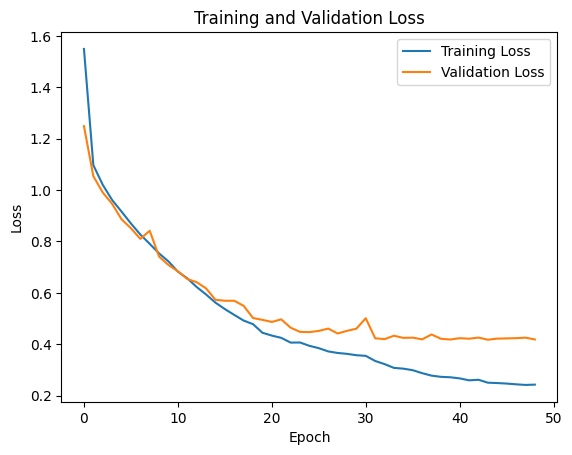

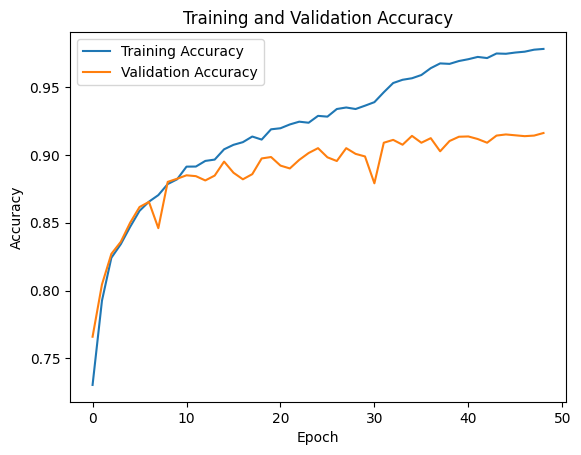

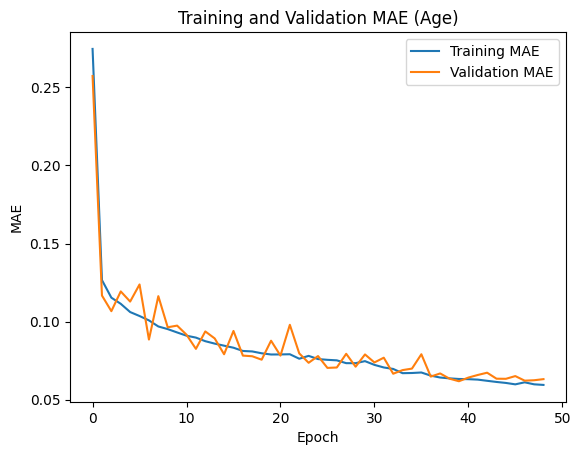

In [13]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

if 'gender_output_accuracy' in history.history:
    plt.plot(history.history['gender_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if 'age_output_mae' in history.history:
    plt.plot(history.history['age_output_mae'], label='Training MAE')
    plt.plot(history.history['val_age_output_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE (Age)')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# 7. Faire des prédictions et tester notre modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


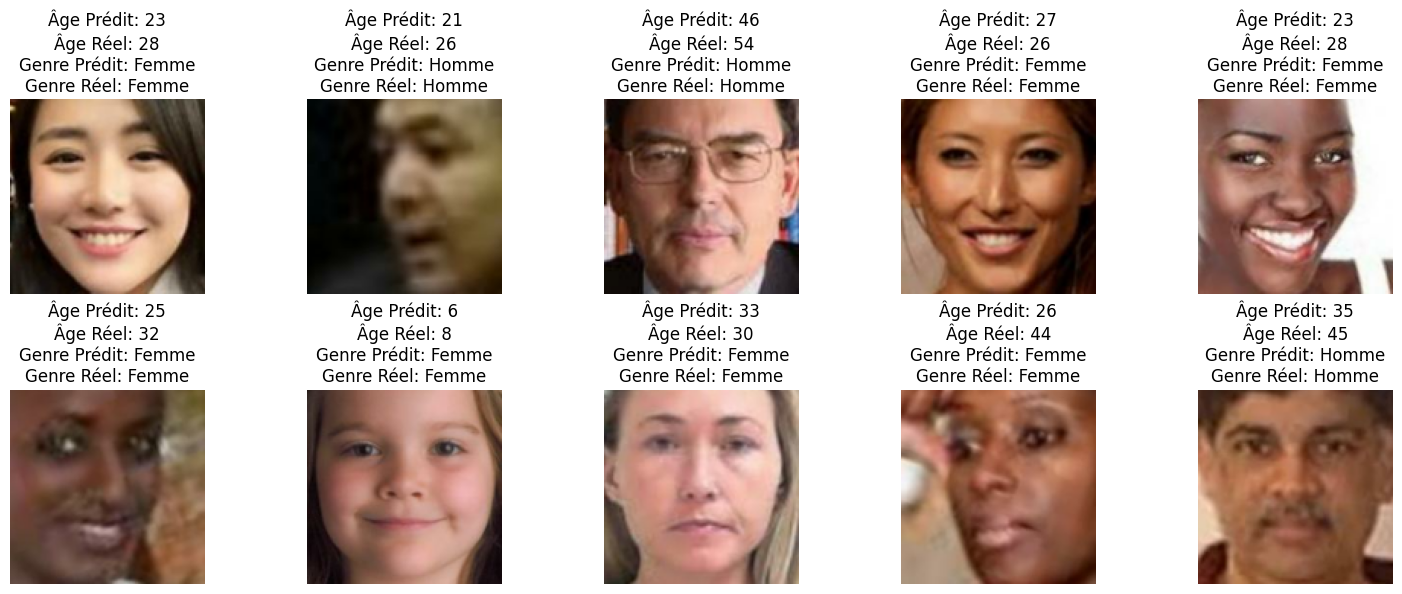

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Mélanger les données et sélectionner 10 images aléatoires
test_subset = test_ds.shuffle(buffer_size=10000, seed=42)

for images, labels in test_subset.take(1):
    # Sélectionner les 10 premières images
    images_np = images[:10].numpy()  # Convertir en NumPy
    
    if images_np.max() <= 1.0:
        images_np = (images_np * 255).astype('uint8')

    # Séparer les labels pour Âge et Genre
    age_real = labels[0][:10].numpy() * 116  # Âge réel (premier élément)
    gender_real = labels[1][:10].numpy()  # Genre réel (deuxième élément)

    # Prédictions
    predictions = model.predict(images[:10])
    age_preds = predictions[0] * 116  # Prédictions d'âge
    gender_preds = predictions[1]  # Prédictions de genre

    # Décode le genre : 0 = Femme, 1 = Homme
    gender_labels_pred = ["Femme" if g >= 0.5 else "Homme" for g in gender_preds]
    gender_labels_real = ["Femme" if g >= 0.5 else "Homme" for g in gender_real]

    # Création de la figure
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()

    for i in range(10):
        img = images_np[i]
        if img.shape[0] == 3:  # Si (channels, height, width), on réordonne
            img = np.transpose(img, (1, 2, 0))

        # Afficher l'image
        axs[i].imshow(img)
        axs[i].axis('off')

        # Ajouter le titre avec Âge et Genre (prédit et réel)
        axs[i].set_title(
            f"Âge Prédit: {int(age_preds[i].item())}\nÂge Réel: {int(age_real[i].item())}\n"
            f"Genre Prédit: {gender_labels_pred[i]}\nGenre Réel: {gender_labels_real[i]}"
        )

    # Ajustement des espaces
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


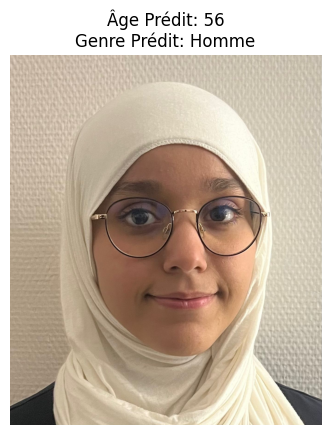

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Charger votre modèle (si ce n'est pas déjà fait)
model_path = '/kaggle/working/models/gender_age_model.h5'

# Fonction pour charger et prétraiter une image
def charger_et_pretraiter_image(img_path, target_size=(128, 128)):
    """
    Charge une image depuis un fichier, la redimensionne et la normalise.
    """
    # Charger l'image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    
    img_array = img_array / 255.0  # Normaliser les pixels entre 0 et 1
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    return img_array

# Chemin vers votre image
img_path = "/kaggle/input/testsurnous/marya2.jpeg"

# Charger et prétraiter l'image
image_test = charger_et_pretraiter_image(img_path)

# Faire une prédiction
predictions = model.predict(image_test)
age_pred = predictions[0] * 116  # Prédiction d'âge (si normalisé pendant l'entraînement)
gender_pred = predictions[1]  # Prédiction de genre

# Décoder le genre : 0 = Femme, 1 = Homme
gender_label_pred = "Femme" if gender_pred >= 0.5 else "Homme"

# Afficher l'image et les prédictions
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(
    f"Âge Prédit: {int(age_pred.item())}\n"
    f"Genre Prédit: {gender_label_pred}"
)
plt.show()